# Introduction

This notebook presents each of the example problems in the official [FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/ftut1.html), but in their super friendly pyironized format. For a description of the underlying physics/mathematics, please see the official documentation. The purpose here is as a rosetta stone to demonstrate the translation into pyiron.

At the moment it's also really a testbed so that I (Liam huber@mpie.de) can play around with our interface class(es) to see what is necessary and helpful across a broad selection of problems. I'd like to codify some of it into unit tests before the end as well.

In [1]:
from pyiron import Project
import pyiron_contrib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pr = Project('fenics_tutorial')
pr.remove_jobs_silently(recursive=True)

# Fundamentals: Solving the Poisson equation

In [3]:
job = pr.create.job.Fenics('poisson', delete_existing_job=True)
job.input.element_type = 'P'
job.input.element_order = 1
job.domain = job.create.domain.unit_square(8, 8)

u_D = job.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)  # String expressions must have valid C++ syntax
job.BC = job.create.bc.dirichlet(u_D)

job.LHS = job.dot(job.grad_u, job.grad_v) * job.dx
job.RHS = job.Constant(-6.0) * job.v * job.dx

In [4]:
job.run()

The job poisson was saved and received the ID: 169


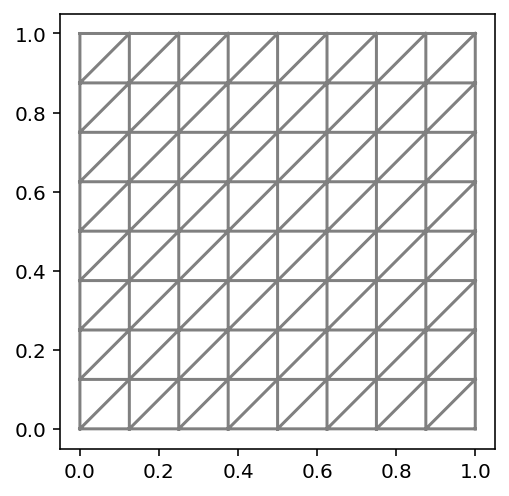

In [5]:
job.plot_mesh()  
# Aha, the example runs on a UnitSquareMesh, but uniformity is not automatic even for simple domains...
# More mesh control has been added to the TODO list, but for this example a tet mesh is fine.

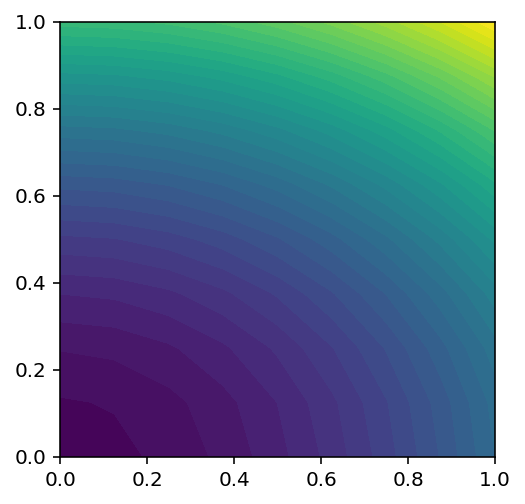

In [6]:
job.plot_u()

In [7]:
error_L2 = job.fenics.errornorm(u_D, job.u, 'L2')

vertex_values_u_D = u_D.compute_vertex_values(job.mesh)
vertex_values_u = job.u.compute_vertex_values(job.mesh)

print('error_L2  =', error_L2)
print('error_max =', np.max(np.abs(vertex_values_u_D - vertex_values_u)))
      
# Try increasing the element order to 3 and the mesh resolution to see the error drop

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


# Deflection of a membrane

In [8]:
job = pr.create.job.Fenics('membrane', delete_existing_job=True)
job.input.mesh_resolution = 64
job.input.element_type = 'P'
job.input.element_order = 2

job.domain = job.create.domain.circle((0, 0), 1)
job.BC = job.create.bc.dirichlet(job.Constant(0))

p = job.Expression('4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))', degree=1, beta=12, R0=0.3)
job.LHS = job.dot(job.grad_u, job.grad_v) * job.dx
job.RHS = p * job.v * job.dx

In [9]:
job.run()

The job membrane was saved and received the ID: 170


In [10]:
job.output.u

[array([0.        , 0.        , 0.        , ..., 0.00687503, 0.00720017,
        0.00031633])]

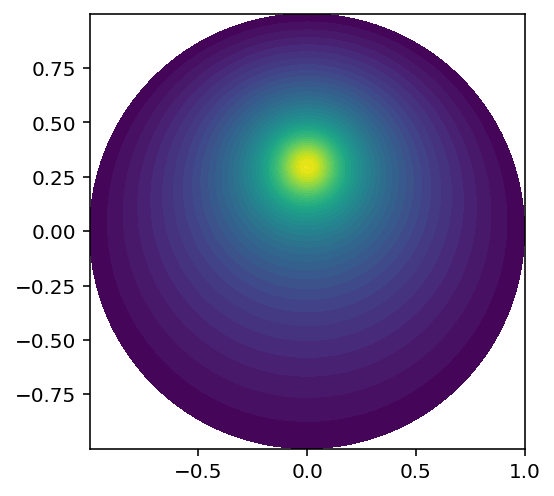

In [11]:
job.plot_u()

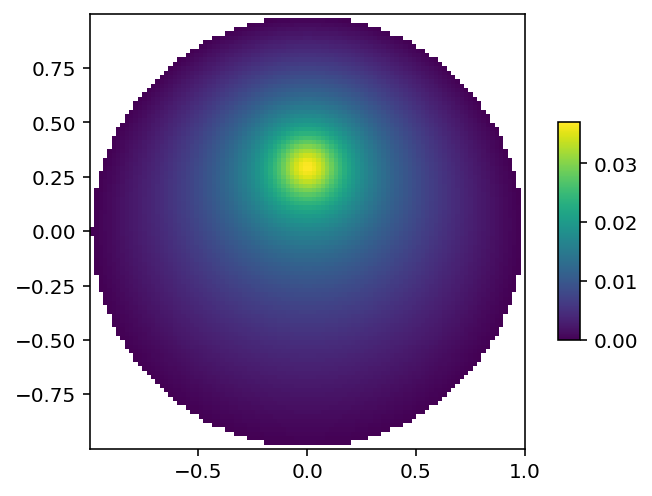

In [12]:
job.plot_output(n_grid=100);  # Our simple output plotter also works for non-square mesh-shapes
# Here we drop the interpolation parameter to see the coarse-grained-ness

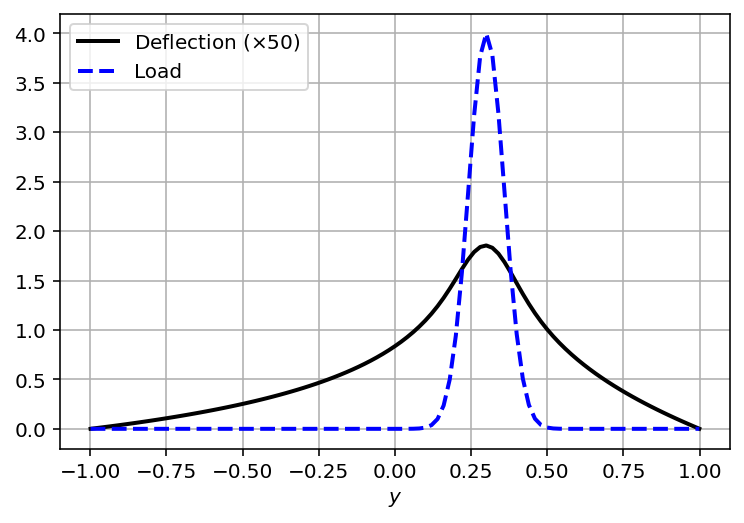

In [13]:
tol = 0.001  # avoid hitting points outside the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]  # 2D points cutting a vertical line through the center of the domain
w_line = np.array([job.u(point) for point in points])
p_line = np.array([p(point) for point in points])

plt.plot(y, 50*w_line, 'k', linewidth=2)  # magnify w
plt.plot(y, p_line, 'b--', linewidth=2)
plt.grid(True)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left');

# The heat equation

In [14]:
total_time = 2.0            # final time
num_steps = 10     # number of time steps
dt = total_time / num_steps # time step size

job = pr.create.job.Fenics('heat', delete_existing_job=True)
job.input.element_types = 'P'
job.input.element_order = 1
job.input.n_steps = 10
job.input.dt = 0.2

job.domain = job.create.domain.unit_square(8, 8)

u_D = job.Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=3, beta=1.2, t=0)
job.BC = job.create.bc.dirichlet(u_D)

u_n = job.interpolate_function(u_D)  # TODO: Make job method with automatic V

f = job.Constant(u_D.beta - 2 - 2*u_D.alpha)
job.F = job.u * job.v * job.dx + dt * job.dot(job.grad_u, job.grad_v) * job.dx \
        - (u_n + job.input.dt * f) * job.v * job.dx

job.time_dependent_expressions.append(u_D)
job.assigned_u = u_n

# TODO?: Add error calculation to the run loop? Interpolation at each step seems costly...

In [15]:
job.run()

The job heat was saved and received the ID: 171


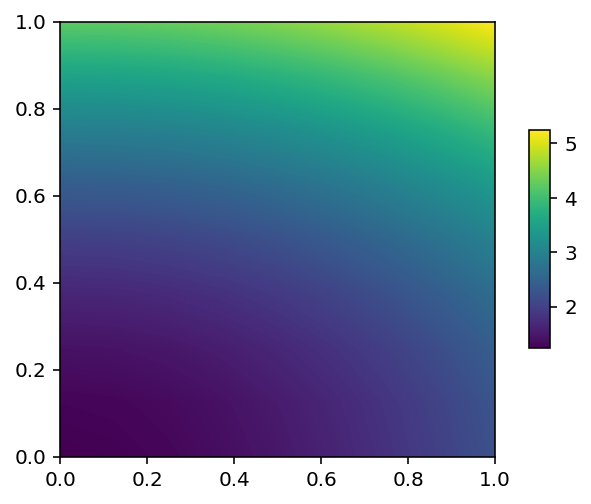

In [16]:
job.plot_output(frame=0);

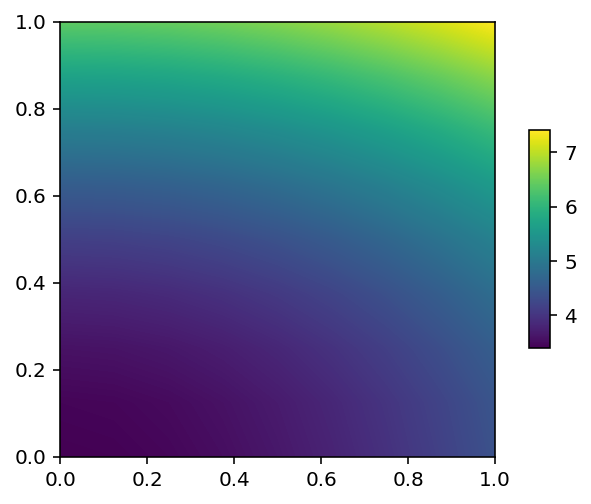

In [17]:
job.plot_output(frame=-1);

# Diffusion of a Gaussian function

In [18]:
job = pr.create.job.Fenics('gauss', delete_existing_job=True)
total_time = 2.0  # final time
num_steps = 50  # number of time steps
dt = total_time / num_steps  # time step size

job.input.element_types = 'P'
job.input.element_order = 1
job.input.n_steps = num_steps
job.input.dt = dt

job.domain = job.create.domain.regular_mesh.rectangle((-2, -2), (2, 2), 30, 30)
job.BC = job.create.bc.dirichlet(job.Constant(0))

u_0 = job.Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', degree=2, a=5)
u_n = job.interpolate_function(u_0)

f = job.Constant(0)
job.F = job.u * job.v * job.dx + job.input.dt * job.dot(job.grad_u, job.grad_v) * job.dx \
        - (u_n + job.input.dt * f) * job.v * job.dx

job.assigned_u = u_n

In [19]:
job.run()

The job gauss was saved and received the ID: 172


(<matplotlib.image.AxesImage at 0x7fec35c2a970>,
 <Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>)

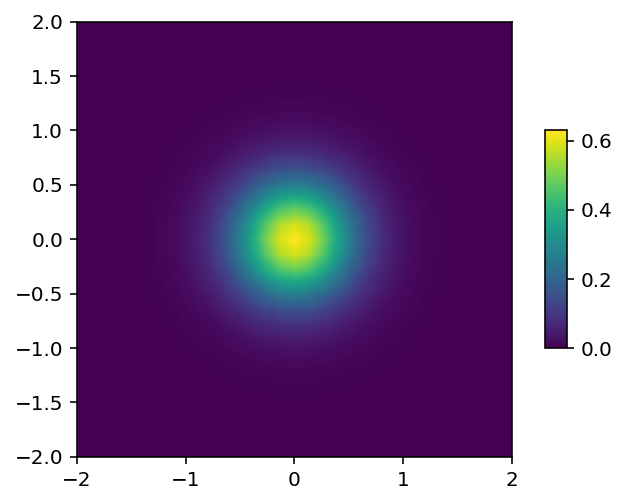

In [20]:
job.plot_output(frame=0)